<a href="https://colab.research.google.com/github/patbaa/demo_notebooks/blob/master/segmentation_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download Oxford's pet dataset
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
    
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

!mkdir -p images/img
!mkdir -p annotations/trimaps/img

!mv images/* images/img
!mv annotations/trimaps/* annotations/trimaps/img/

--2020-11-22 22:31:15--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  34.7MB/s    in 22s     

2020-11-22 22:31:38 (34.0 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2020-11-22 22:31:38--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  17.8MB/s    in 1.0s    

2020-11-22 22:31:39 (17.8 M

In [2]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras import Model
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [3]:
img  = cv2.imread('images/img/Abyssinian_1.jpg')
mask = cv2.imread('annotations/trimaps/img/Abyssinian_1.png', 0)

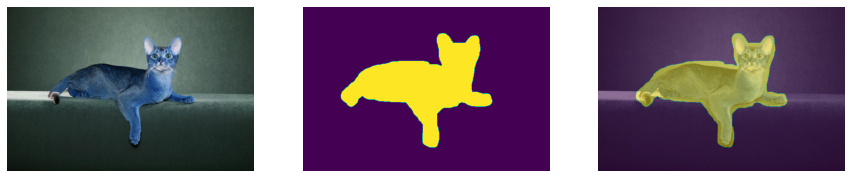

In [4]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(img)
plt.axis('off')
plt.subplot(132)
plt.imshow(mask != 2)
plt.axis('off')
plt.subplot(133)
plt.imshow(img)
plt.imshow(mask != 2, alpha=0.5)
plt.axis('off')
plt.show()

In [5]:
# source: https://github.com/zhixuhao/unet
# rescaled to 128px instead of 256px
# removed dropout rate (set to 0)
# added batchnorm layers
# halved the channels in each layer
drop_rate = 0
n_channel_base = 32

inp = Input(shape=(128, 128, 3))
conv1 = Conv2D(n_channel_base, 3, activation = 'relu', padding = 'same')(inp)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(n_channel_base, 3, activation = 'relu', padding = 'same')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(n_channel_base*2, 3, activation = 'relu', padding = 'same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(n_channel_base*2, 3, activation = 'relu', padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(n_channel_base*4, 3, activation = 'relu', padding = 'same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(n_channel_base*4, 3, activation = 'relu', padding = 'same')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(n_channel_base*8, 3, activation = 'relu', padding = 'same')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(n_channel_base*8, 3, activation = 'relu', padding = 'same')(conv4)
conv4 = BatchNormalization()(conv4)
drop4 = Dropout(drop_rate)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(n_channel_base*16, 3, activation = 'relu', padding = 'same')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(n_channel_base*16, 3, activation = 'relu', padding = 'same')(conv5)
conv5 = BatchNormalization()(conv5)
drop5 = Dropout(drop_rate)(conv5)

up6 = Conv2D(n_channel_base*8, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4, up6], axis = 3)
merge6 = BatchNormalization()(merge6)
conv6 = Conv2D(n_channel_base*8, 3, activation = 'relu', padding = 'same')(merge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(n_channel_base*8, 3, activation = 'relu', padding = 'same')(conv6)
conv6 = BatchNormalization()(conv6)

up7 = Conv2D(n_channel_base*4, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
merge7 = BatchNormalization()(merge7)
conv7 = Conv2D(n_channel_base*4, 3, activation = 'relu', padding = 'same')(merge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(n_channel_base*4, 3, activation = 'relu', padding = 'same')(conv7)
conv7 = BatchNormalization()(conv7)


up8 = Conv2D(n_channel_base*2, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
merge8 = BatchNormalization()(merge8)
conv8 = Conv2D(n_channel_base*2, 3, activation = 'relu', padding = 'same')(merge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(n_channel_base*2, 3, activation = 'relu', padding = 'same')(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv2D(n_channel_base, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
merge9 = BatchNormalization()(merge9)
conv9 = Conv2D(n_channel_base, 3, activation = 'relu', padding = 'same')(merge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(n_channel_base, 3, activation = 'relu', padding = 'same')(conv9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same')(conv9)
conv9 = BatchNormalization()(conv9)
# sigmoid, because we have only 0-1 labels
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inp, outputs = conv10)
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [6]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        batch_normalization[0][0]        
_______________________________________________________________________________________

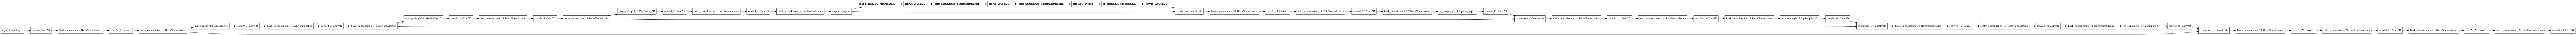

In [7]:
plot_model(model, dpi=60, rankdir='LR')

In [8]:
def imp_preprocess(img):
    img  = img.astype(float)
    return img/255.

def mask_preprocess(img):
    return img != 2

image_datagen = ImageDataGenerator(preprocessing_function = imp_preprocess, validation_split=0.2)
mask_datagen  = ImageDataGenerator(preprocessing_function = mask_preprocess, validation_split=0.2)  

train_image_generator = image_datagen.flow_from_directory("images/", target_size = (128, 128), 
                                                    class_mode=None, seed=42, batch_size=32,
                                                    subset='training')
train_mask_generator  = mask_datagen.flow_from_directory("annotations/trimaps/", target_size = (128, 128), 
                                                   class_mode=None, seed=42, batch_size=32,
                                                   subset='training', color_mode='grayscale')

test_image_generator = image_datagen.flow_from_directory("images/", target_size = (128, 128), 
                                                    class_mode=None, seed=42, batch_size=32, 
                                                    subset='validation')
test_mask_generator  = mask_datagen.flow_from_directory("annotations/trimaps/", target_size = (128, 128), 
                                                   class_mode=None, seed=42, batch_size=32,
                                                   subset='validation', color_mode='grayscale')

train_generator = zip(train_image_generator, train_mask_generator)
test_generator  = zip(test_image_generator, test_mask_generator)

Found 5912 images belonging to 1 classes.
Found 5912 images belonging to 1 classes.
Found 1478 images belonging to 1 classes.
Found 1478 images belonging to 1 classes.


In [9]:
!ls images/img/ | wc

   7393    7393  148901


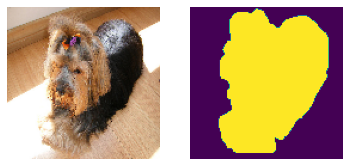

In [10]:
plt.subplot(121)
plt.imshow(train_image_generator[0][0])
plt.axis('off')

plt.subplot(122)
plt.imshow(train_mask_generator[0][0][...,0])
plt.axis('off')
plt.show()

In [11]:
results_first_batch = model.predict(test_image_generator[0])
_ = test_mask_generator[0]

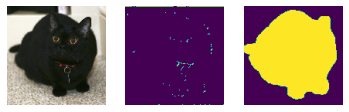

In [12]:
idx = 0
plt.subplot(131)
plt.imshow(test_image_generator[0][idx])
plt.axis('off')

plt.subplot(132)
plt.imshow(results_first_batch[idx][...,0] > 0.5)
plt.axis('off')

plt.subplot(133)
plt.imshow(test_mask_generator[0][idx][...,0])
plt.axis('off')
plt.show()

In [13]:
model.fit(train_generator, steps_per_epoch=len(train_image_generator),
          validation_data=test_generator, validation_steps = len(test_image_generator),
          epochs=10, verbose=1, shuffle=False)

Epoch 1/10
185/185 [==============================] - 56s 304ms/step - loss: 0.4520 - accuracy: 0.8087 - val_loss: 0.8237 - val_accuracy: 0.5561
Epoch 2/10
185/185 [==============================] - 55s 295ms/step - loss: 0.3434 - accuracy: 0.8730 - val_loss: 0.4686 - val_accuracy: 0.7905
Epoch 3/10
185/185 [==============================] - 55s 296ms/step - loss: 0.3044 - accuracy: 0.8947 - val_loss: 0.3693 - val_accuracy: 0.8518
Epoch 4/10
185/185 [==============================] - 55s 297ms/step - loss: 0.2751 - accuracy: 0.9096 - val_loss: 0.3448 - val_accuracy: 0.8623
Epoch 5/10
185/185 [==============================] - 55s 299ms/step - loss: 0.2478 - accuracy: 0.9229 - val_loss: 0.3189 - val_accuracy: 0.8774
Epoch 6/10
185/185 [==============================] - 55s 299ms/step - loss: 0.2262 - accuracy: 0.9324 - val_loss: 0.3363 - val_accuracy: 0.8669
Epoch 7/10
185/185 [==============================] - 55s 295ms/step - loss: 0.2065 - accuracy: 0.9407 - val_loss: 0.3197 - val_ac

In [14]:
results_first_batch_trained = model.predict(test_image_generator[0])
_ = test_mask_generator[0]

In [15]:
def plot_res(idx, batchid = 0):
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(test_image_generator[batchid][idx])
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(results_first_batch_trained[idx][...,0] > 0.5)
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(test_mask_generator[batchid][idx][...,0])
    plt.axis('off')
    plt.show()

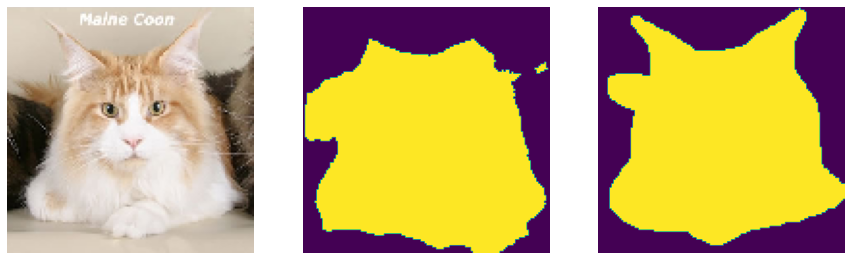

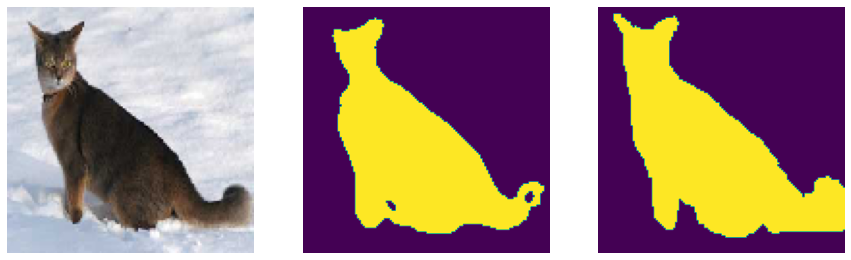

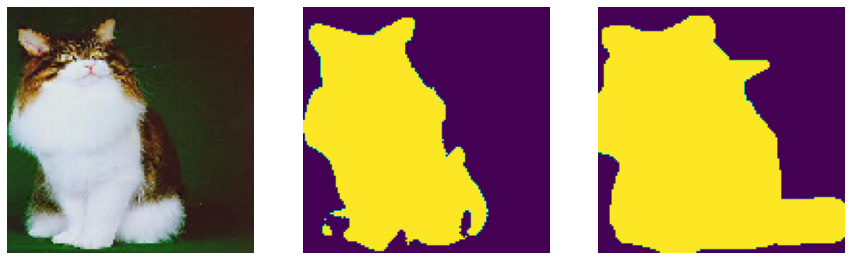

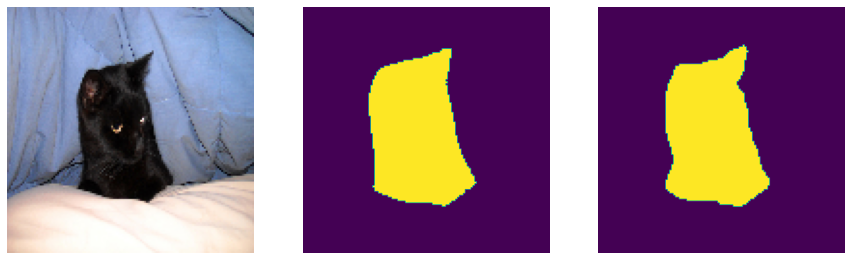

In [16]:
plot_res(0)
plot_res(7)
plot_res(10)
plot_res(15)

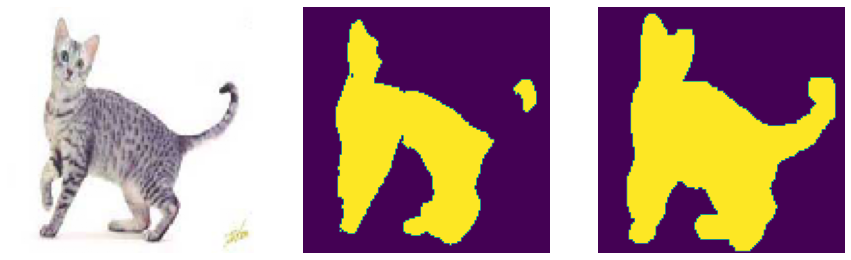

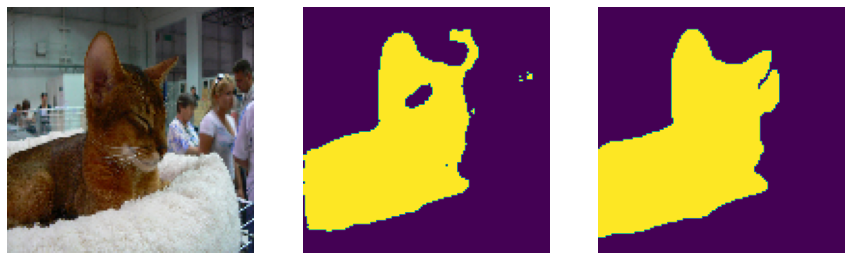

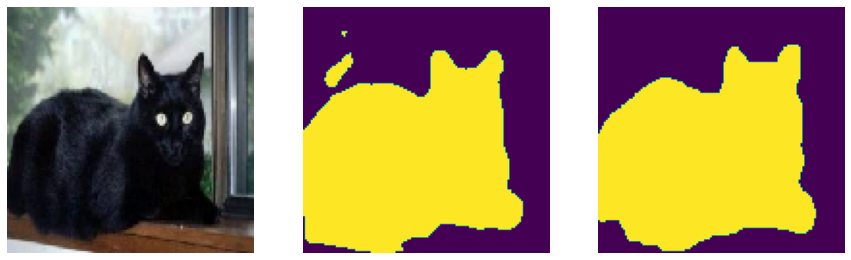

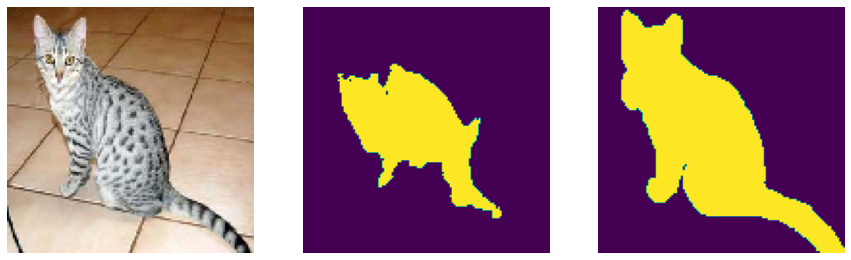

In [17]:
results_first_batch_trained = model.predict(test_image_generator[12])
_ = test_mask_generator[12]

plot_res(0, 12)
plot_res(7, 12)
plot_res(10, 12)
plot_res(15, 12)

Oxford Pets dataset is relatively simple. Only one object is presented and the object significantly differs from the background.

For real-world datasets one might need
 - larger model
 - more data
 - proper data augmentation
 - longer training
 - use ImageNet pre-trained weights where possible